# 데이터 준비

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터 탐색

In [2]:
# 훈련 데이터셋 정보
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [3]:
# 테스트 데이터셋 정보
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


## 결측치 확인

In [4]:
# 결측치 개수 확인
print('-- train dataset --')
print(train_data.isna().sum())

print('-- test dataset --')
print(test_data.isna().sum())

-- train dataset --
id          0
document    5
label       0
dtype: int64
-- test dataset --
id          0
document    3
label       0
dtype: int64


train 데이터셋에서 5개, test 데이터셋에서 3개로 결측치가 발견되었다.

해당 결측치를 확인해보았다.

In [5]:
# 결측치 확인해보기
print('-- train dataset --')
print(train_data[train_data['document'].isna()])

print('-- test dataset --')
print(test_data[test_data['document'].isna()])

-- train dataset --
             id document  label
25857   2172111      NaN      1
55737   6369843      NaN      1
110014  1034280      NaN      0
126782  5942978      NaN      0
140721  1034283      NaN      0
-- test dataset --
            id document  label
5746    402110      NaN      1
7899   5026896      NaN      0
27097   511097      NaN      1


이제 결측치를 제거해보자

In [6]:
# 결측치 제거
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# 결측치가 제거되었는지 확인하기
print('-- train dataset after dropna --')
print(train_data.isna().sum())

print('-- test dataset after dropna --')
print(test_data.isna().sum())

-- train dataset after dropna --
id          0
document    0
label       0
dtype: int64
-- test dataset after dropna --
id          0
document    0
label       0
dtype: int64


결측치가 제거된 것을 확인했으니 이제 중복 데이터를 확인해보자

## 중복 데이터 처리

In [7]:
# 중복 데이터가 존재하는지 확인하기
print('id:', train_data['id'].duplicated().any())
print('document', train_data['document'].duplicated().any())

id: False
document True


id는 모두 고유값을 가지고 있다. 하지만 document는 중복된 데이터가 있다는 것을 확인할 수 있다.

학습 데이터셋과 테스트 데이터셋에서 중복데이터를 확인해보자

In [8]:
# 중복 데이터 확인
print('train dataset')
print(train_data[train_data.duplicated(subset=['document'])])

print('test dataset')
print(test_data[test_data.duplicated(subset=['document'])])

train dataset
             id document  label
1058    5890638        4      0
1097    2062443       쵝오      1
1248    3502685       최고      1
1483     775332       최고      1
1707    8009134      재밌다      1
...         ...      ...    ...
149919  6502490        짱      1
149949  3924716    OO 영화      0
149960  6368431     지루하다      0
149966  6735753        1      0
149987  7669621  재미있어요^^      1

[3813 rows x 3 columns]
test dataset
            id                  document  label
857    2084375                       bad      0
956     195683                     재미있어요      1
1089   2235528                       볼만함      1
1149   4409686                         굿      1
1600   3805716                        최고      1
...        ...                       ...    ...
49731  7437033                        별로      0
49760  5890883                      최악이다      0
49767  4032953                        최고      1
49841  8097768  2년이 지나도 잊혀지지 않는 소중한 드라마.      1
49934  6929887                      

이제 중복 데이터를 지우도록 하자

In [9]:
# 중복 데이터 제거
train_data = train_data.drop_duplicates(subset=['document'])
test_data = test_data.drop_duplicates(subset=['document'])

# 중복 데이터가 제거되었는지 확인
print('train dataset')
print(train_data['document'].duplicated().any())

print('test dataset')
print(test_data['document'].duplicated().any())

train dataset
False
test dataset
False


# 데이터로더 구성

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [11]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from tqdm import tqdm

# 형태소 분리기
tokenizer = Mecab()
# 문장에서 제외할 단어 목록
# 조사처럼 문법적 의미만 있거나 그 분류 결과에 영향을 주지 않을 단어를 뺀다
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
# 사용할 단어 개수
num_words = 3000


def load_data(train_data, test_data, num_words=num_words):
    # 결측치 제거
    train_data.dropna(inplace=True)
    test_data.dropna(inplace=True)
    
    # 중복 데이터 제거
    train_data = train_data.drop_duplicates(subset=['document'])
    test_data = test_data.drop_duplicates(subset=['document'])
    
    # 데이터셋 내 모든 형태소 수집
    all_word_list = []
    for _, row in tqdm(train_data.iterrows(), total=train_data.shape[0]):
        word_list = tokenizer.morphs(row['document'])
        word_list = [word for word in word_list if word not in stopwords]
        all_word_list.extend(word_list)
    
    for _, row in tqdm(test_data.iterrows(), total=test_data.shape[0]):
        word_list = tokenizer.morphs(row['document'])
        word_list = [word for word in word_list if word not in stopwords]
        all_word_list.extend(word_list)
        
    # 단어와 정수를 맵핑
    counter = Counter(all_word_list)
    word_to_index = {k:(v+3) for v, (k, _) in enumerate(sorted(counter.items(), key=lambda x: x[1], reverse=True))}
    word_to_index['<PAD>'] = 0    # 패딩용 토큰
    word_to_index['<BOS>'] = 1    # 문장 시작 토큰
    word_to_index['<UNK>'] = 2    # 사전에 없는 단어 토큰
    word_to_index['<UNUSED>'] = 3 # 사전에서 짤린 단어 토큰
    
    # 빈도를 기준으로 num_words개의 단어만 고유 토큰 부여
    # 빈도가 많은 단어만 학습시키기
    if num_words != -1:
        for k, v in word_to_index.items():
            if v > num_words:
                word_to_index[k] = 3
    
    # 훈련 데이터셋을 입력 데이터와 정답 데이터로 분리
    x_train = train_data['document'].values
    y_train = train_data['label'].values
    
    # 테스트 데이터셋을 입력 데이터와 정답 데이터로 분리
    x_test = test_data['document'].values
    y_test = test_data['label'].values
    
    return x_train, y_train, x_test, y_test, word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

100%|██████████| 49157/49157 [00:08<00:00, 5971.85it/s]


In [12]:
# 토큰 -> 단어로 바꿔주는 딕셔너리
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

{3: '<UNUSED>',
 4: '영화',
 5: '다',
 6: '고',
 7: '하',
 8: '을',
 9: '보',
 10: '..',
 11: '게',
 12: ',',
 13: '!',
 14: '지',
 15: '있',
 16: '없',
 17: '?',
 18: '좋',
 19: '나',
 20: '었',
 21: '만',
 22: '는데',
 23: '너무',
 24: '봤',
 25: '안',
 26: '적',
 27: '정말',
 28: '로',
 29: '음',
 30: '것',
 31: '아',
 32: '네요',
 33: '재밌',
 34: '어',
 35: '같',
 36: '점',
 37: '진짜',
 38: '지만',
 39: '했',
 40: '에서',
 41: '기',
 42: '네',
 43: '않',
 44: '거',
 45: '았',
 46: '수',
 47: '되',
 48: '면',
 49: 'ㅋㅋ',
 50: '연기',
 51: '말',
 52: '인',
 53: '주',
 54: '최고',
 55: '평점',
 56: '내',
 57: '~',
 58: '이런',
 59: '던',
 60: '어요',
 61: '왜',
 62: '할',
 63: '겠',
 64: '1',
 65: '해',
 66: '스토리',
 67: '습니다',
 68: 'ㅋㅋㅋ',
 69: '...',
 70: '아니',
 71: '생각',
 72: '더',
 73: '그',
 74: '드라마',
 75: '싶',
 76: '사람',
 77: '듯',
 78: '때',
 79: '감동',
 80: '배우',
 81: '함',
 82: '까지',
 83: '본',
 84: '볼',
 85: '내용',
 86: '보다',
 87: '만들',
 88: '뭐',
 89: '알',
 90: '감독',
 91: '라',
 92: '그냥',
 93: '재미',
 94: '중',
 95: '시간',
 96: '지루',
 97: '재미있',
 98: '년'

# 모델 구성을 위한 데이터 분석 및 가공

In [13]:
print("train:", X_train.shape, y_train.shape)
print("test:", X_test.shape, y_test.shape)

train: (146182,) (146182,)
test: (49157,) (49157,)


## 모든 문장을 토큰화

In [14]:
X_train_tokenized = get_encoded_sentences(X_train, word_to_index)
X_test_tokenized = get_encoded_sentences(X_test, word_to_index)

print(X_train_tokenized[:5])

[[1, 31, 2, 37, 2, 736], [1, 2, 2, 2, 2], [1, 2], [1, 3, 2, 2, 2, 2, 3], [1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2]]


# 문장 길이의 분포 살펴보기

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


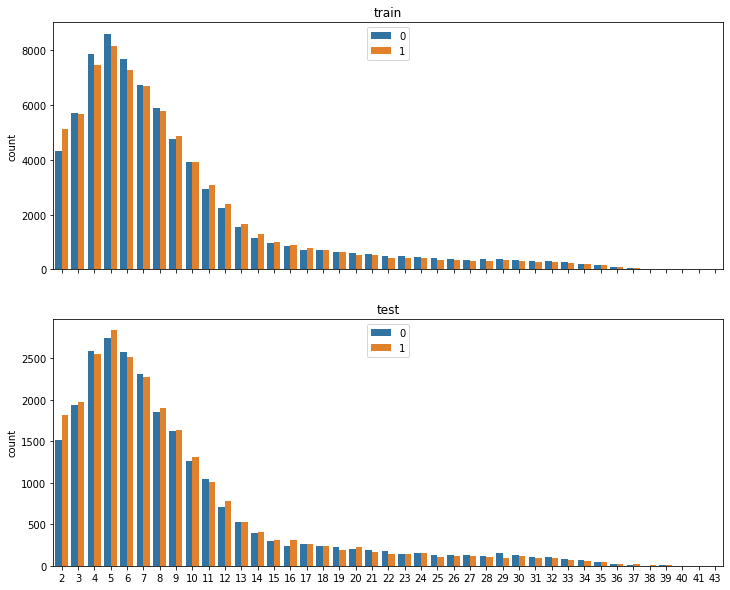

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


# 각 문장의 길이를 측정
X_train_length = list(map(len, X_train_tokenized))
X_test_length = list(map(len, X_test_tokenized))

# 학습 데이터셋과 테스트 데이터셋의 문장 길이 분포 그래프 그리기
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

sns.countplot(X_train_length, ax=axes[0], hue=y_train)
sns.countplot(X_test_length, ax=axes[1], hue=y_test)

axes[0].set_title('train')
axes[1].set_title('test')


plt.show()

# 문장 길이의 평균과 표준편차

In [16]:
sentence_lengths = np.hstack([X_train_length, X_test_length])

length_mean = sentence_lengths.mean()
length_std = sentence_lengths.std()

print("mean:", length_mean)
print("std:", length_std)

mean: 8.736985445814712
std: 6.522358644961045


# 평균과 표준편차로 최대 문장 길이 결정하기

In [17]:
import math

# 평균과 표준편차로 최대 문장 길이 계산
max_length = math.floor(length_mean + 3 * length_std)

# 최대 문장 길이보다 짧은 문장 비율 확인하기
count_shorter_sentences = len(list(filter(lambda x: x < max_length, sentence_lengths)))

print("문장의 최대 길이를 {}로 잡으면".format(max_length))
print("{:.2f}%의 문장들이 잘리지 않습니다.".format(count_shorter_sentences / len(sentence_lengths) * 100))

문장의 최대 길이를 28로 잡으면
96.78%의 문장들이 잘리지 않습니다.


# 토큰화된 문장에 패딩 적용하기

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 학습 데이터셋 패딩 적용
X_train_padding = pad_sequences(X_train_tokenized, value=word_to_index['<PAD>'], maxlen=max_length, padding='pre')
# 테스트 데이터셋 패딩 적용
X_test_padding = pad_sequences(X_test_tokenized, value=word_to_index['<PAD>'], maxlen=max_length, padding='pre')

X_train_padding[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  31,   2,  37,
          2, 736],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   2,   2,
          2,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   1,   3,   2,   2,   2,
          2,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1,   2,   2,   2,   2,   2,   2,   2,   3,   2,
          2,   2]], dtype=int32)

# 라벨 분포 확인하기

In [19]:
# 라벨별 데이터 개수 확인하기
print('-- train dataset --')
print(train_data.groupby('label').count())

print('-- test dataset --')
print(test_data.groupby('label').count())

-- train dataset --
          id  document
label                 
0      73342     73342
1      72840     72840
-- test dataset --
          id  document
label                 
0      24446     24446
1      24711     24711


# 모델 구성 및 validation set 구성

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU

# 임베딩 벡터의 크기
embedding_size = 16

In [21]:
# Simple RNN 모델
model_rnn = Sequential([
    Embedding(num_words, embedding_size),
    SimpleRNN(1, activation='sigmoid')
], name="SimpleRNNModel")
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn.summary()

Model: "SimpleRNNModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          48000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 1)                 18        
Total params: 48,018
Trainable params: 48,018
Non-trainable params: 0
_________________________________________________________________


In [22]:
# LSTM 모델
model_lstm = Sequential([
    Embedding(num_words, embedding_size),
    LSTM(1, activation='sigmoid')
], name="LSTMModel")
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "LSTMModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          48000     
_________________________________________________________________
lstm (LSTM)                  (None, 1)                 72        
Total params: 48,072
Trainable params: 48,072
Non-trainable params: 0
_________________________________________________________________


In [23]:
# GRU 모델
model_gru = Sequential([
    Embedding(num_words, embedding_size),
    GRU(1, activation='sigmoid')
], name="GRUModel")
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_gru.summary()

Model: "GRUModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          48000     
_________________________________________________________________
gru (GRU)                    (None, 1)                 57        
Total params: 48,057
Trainable params: 48,057
Non-trainable params: 0
_________________________________________________________________


In [24]:
from sklearn.model_selection import train_test_split

# 학습 데이터셋에서 검증용 데이터셋 분리하기
X_train, X_val, y_train, y_val = train_test_split(X_train_padding, y_train, test_size=0.2, random_state=42)

print("train:", X_train.shape, y_train.shape)
print("val:", X_val.shape, y_val.shape)

train: (116945, 28) (116945,)
val: (29237, 28) (29237,)


# 모델 훈련 개시

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

# 학습에 공통된 하이퍼 파라미터 적용
fit_options = {
    'epochs': 10,                      # 훈련 횟수
    'batch_size': 512,                 # 배치 사이즈
    'callbacks': [EarlyStopping(patient=3)],    # 조기 종료 (검증 데이터셋에서 성능 향상이 되지 않았다면 훈련 종료)
    'validation_data': (X_val, y_val), # 검증 데이터셋
    'verbose': 1,                      # 모델 훈련 정보 표시
    'workers': 4                       # 프로세스 수
}

# 모델 학습
print("Training SimpleRNN ...")
history_rnn = model_rnn.fit(X_train, y_train, **fit_options)
print("Training LSTM ...")
history_lstm = model_lstm.fit(X_train, y_train, **fit_options)
print("Training GRU ...")
history_gru = model_gru.fit(X_train, y_train, **fit_options)

Training SimpleRNN ...
Epoch 1/10
229/229 [==============================] - 8s 29ms/step - loss: 0.6906 - accuracy: 0.5256 - val_loss: 0.6819 - val_accuracy: 0.5297
Training LSTM ...
Epoch 1/10
229/229 [==============================] - 13s 54ms/step - loss: 0.6909 - accuracy: 0.5435 - val_loss: 0.6784 - val_accuracy: 0.5947
Training GRU ...
Epoch 1/10
229/229 [==============================] - 17s 69ms/step - loss: 0.6827 - accuracy: 0.5663 - val_loss: 0.6654 - val_accuracy: 0.5978


# Loss, Accuracy 그래프 시각화

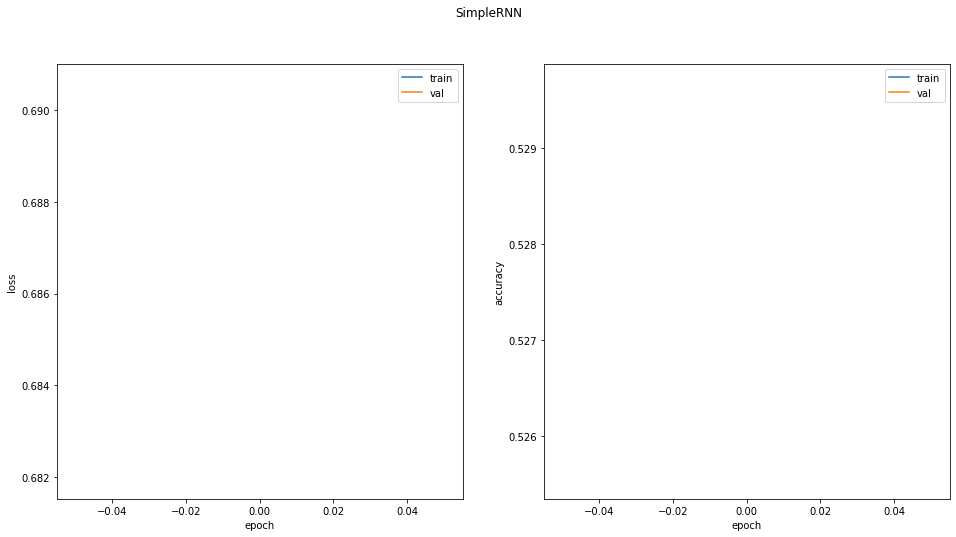

In [27]:
# SimpleRNN 모델 그래프
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

fig.suptitle('SimpleRNN')

# loss 그래프
axes[0].plot(history_rnn.history['loss'])
axes[0].plot(history_rnn.history['val_loss'])
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend(['train', 'val'])

# 정확도 그래프
axes[1].plot(history_rnn.history['accuracy'])
axes[1].plot(history_rnn.history['val_accuracy'])
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].legend(['train', 'val'])

plt.show()

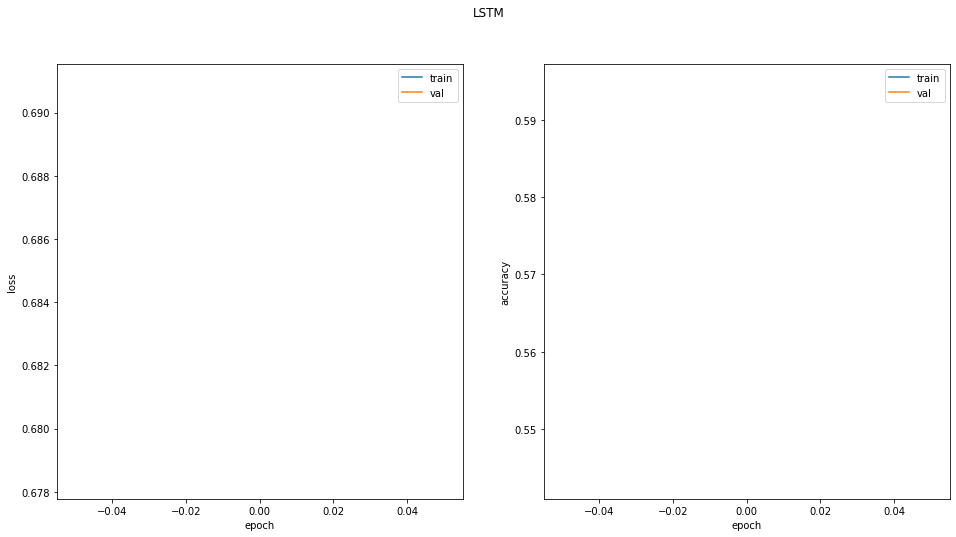

In [28]:
# LSTM 모델 그래프
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

fig.suptitle('LSTM')

# loss 그래프
axes[0].plot(history_lstm.history['loss'])
axes[0].plot(history_lstm.history['val_loss'])
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend(['train', 'val'])

# 정확도 그래프
axes[1].plot(history_lstm.history['accuracy'])
axes[1].plot(history_lstm.history['val_accuracy'])
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].legend(['train', 'val'])

plt.show()

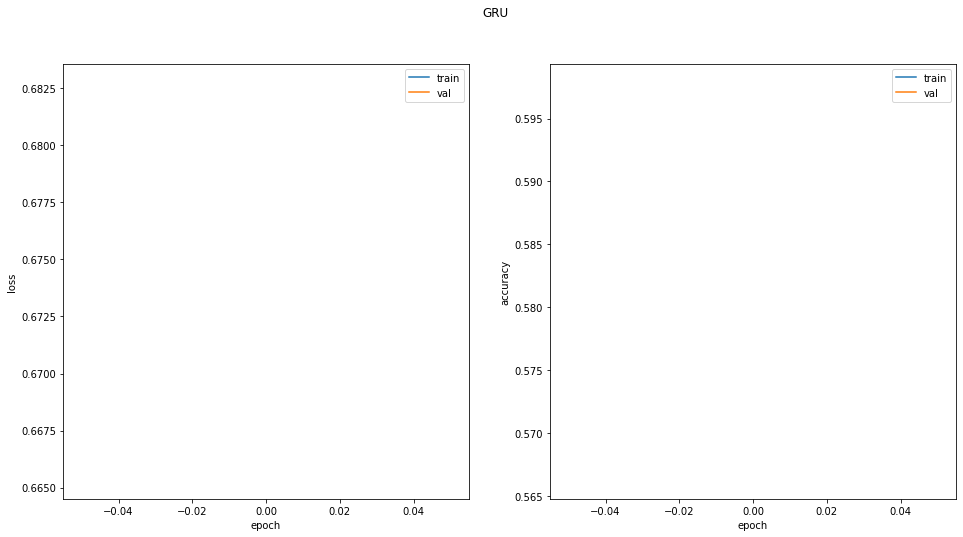

In [29]:
# GRU 모델 그래프
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

fig.suptitle('GRU')

# loss 그래프
axes[0].plot(history_gru.history['loss'])
axes[0].plot(history_gru.history['val_loss'])
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend(['train', 'val'])

# 정확도 그래프
axes[1].plot(history_gru.history['accuracy'])
axes[1].plot(history_gru.history['val_accuracy'])
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].legend(['train', 'val'])

plt.show()

# 학습된 Embedding 레이어 분석

In [30]:
# 모델의 Embedding 파라미터 저장
def save_lookup_table(model):
    # 모델의 Embedding 파라미터 저장하기
    word2vec_file_path = '{}.txt'.format(model.name)
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(num_words-4, embedding_size))

    # 파라미터 기록
    vectors = model.get_weights()[0]
    for i in range(4, num_words):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()

In [31]:
# 세 모델의 룩업 테이블 저장
save_lookup_table(model_rnn)
save_lookup_table(model_lstm)
save_lookup_table(model_gru)

In [42]:
from gensim.models.keyedvectors import Word2VecKeyedVectors


# 단어 유사도 검증
def query_nearest_words(query, model_name):
    file_path = '{}.txt'.format(model_name)
    # 룩업 테이블(Embedding 파라미터) 불러오기
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(file_path)
    nearest = word_vectors.similar_by_word(query) # 가장 유사한 단어 찾기
    print(nearest[:5])

In [43]:
query = '액션'
model_names = [model_rnn.name, model_lstm.name, model_gru.name]


# 각 모델마다 단어 유사도 테스트
for model_name in model_names:
    query_nearest_words(query, model_name)

[('상태', 0.7456886768341064), ('고딩', 0.7149350643157959), ('명화', 0.7040143013000488), ('반영', 0.7021762728691101), ('딸', 0.6749677658081055)]
[('주성치', 0.7778959274291992), ('사고', 0.7144546508789062), ('갑', 0.7064359784126282), ('졌', 0.7058973908424377), ('ㅇㅇ', 0.7054958939552307)]
[('유쾌', 0.9388126134872437), ('엄청', 0.9237165451049805), ('비록', 0.9092352986335754), ('번', 0.8990912437438965), ('정말', 0.89289391040802)]


# 한국어 Word2Vec 임베딩 활용하여 성능 개선

## 한국어 Word2Vec 룩업테이블 불러오기

In [46]:
import os
from tensorflow.keras.initializers import Constant

# 미리 학습된 Word2Vec 룩업 테이블 가져오기
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

# Embedding의 룩업 테이블 준비
embedding_matrix = np.random.rand(num_words, embedding_size)

# embedding_matrix에 Word2Vec 룩업 테이블을 카피한다.
for i in range(4, num_words):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/sentiment_classification/data/word2vec_ko.model.wv.vectors.npy'

## 한국어 Word2Vec 룩업테이블 적용해 모델 만들기

In [ ]:
# Word2Vec 적용한 Simple RNN 모델
model_rnn_w2v = Sequential([
    Embedding(num_words, embedding_size, initializer=Constant(embedding_matrix)),
    SimpleRNN(1, activation='sigmoid')
], name="SimpleRNNModel")
model_rnn_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn_w2v.summary()

In [ ]:
# Word2Vec 적용한 LSTM 모델
model_lstm_w2v = Sequential([
    Embedding(num_words, embedding_size, initializer=Constant(embedding_matrix)),
    LSTM(1, activation='sigmoid')
], name="LSTMModel")
model_lstm_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_w2v.summary()

In [ ]:
# Word2Vec 적용한 GRU 모델
model_gru_w2v = Sequential([
    Embedding(num_words, embedding_size, initializer=Constant(embedding_matrix)),
    SimpleRNN(1, activation='sigmoid')
], name="GRUModel")
model_gru_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_gru_w2v.summary()

## Word2Vec 적용한 모델 학습

In [ ]:
# Word2Vec 적용한 모델 학습
print("Training SimpleRNN ...")
history_rnn_w2v = model_rnn_w2v.fit(X_train, y_train, **fit_options)
print("Training LSTM ...")
history_lstm_w2v = model_lstm_w2v.fit(X_train, y_train, **fit_options)
print("Training GRU ...")
history_gru_w2v = model_gru_w2v.fit(X_train, y_train, **fit_options)

## Word2Vec 적용 모델의 loss, accuracy 추이 보기

In [ ]:
# SimpleRNN 모델 그래프
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

fig.suptitle('SimpleRNN with Word2Vec')

# loss 그래프
axes[0].plot(history_rnn_w2v.history['loss'])
axes[0].plot(history_rnn_w2v.history['val_loss'])
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend(['train', 'val'])

# 정확도 그래프
axes[1].plot(history_rnn.history['accuracy'])
axes[1].plot(history_rnn.history['val_accuracy'])
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].legend(['train', 'val'])

plt.show()

In [ ]:
# LSTM 모델 그래프
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

fig.suptitle('LSTM with Word2Vec')

# loss 그래프
axes[0].plot(history_lstm_w2v.history['loss'])
axes[0].plot(history_lstm_w2v.history['val_loss'])
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend(['train', 'val'])

# 정확도 그래프
axes[1].plot(history_lstm.history['accuracy'])
axes[1].plot(history_lstm.history['val_accuracy'])
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].legend(['train', 'val'])

plt.show()

In [ ]:
# GRU 모델 그래프
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

fig.suptitle('GRU with Word2Vec')

# loss 그래프
axes[0].plot(history_gru_w2v.history['loss'])
axes[0].plot(history_gru_w2v.history['val_loss'])
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend(['train', 'val'])

# 정확도 그래프
axes[1].plot(history_gru.history['accuracy'])
axes[1].plot(history_gru.history['val_accuracy'])
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].legend(['train', 'val'])

plt.show()

## 전체 모델 평가 비교하기

In [ ]:
# 기본 Embedding만 사용한 모델 평가하기
rnn_eval = model_rnn.evaluate(X_test, y_test)
lstm_eval = model_lstm.evaluate(X_test, y_test)
gru_eval = model_gru.evaluate(X_test, y_test)

# Word2Vec 적용한 모델 평가하기
rnn_w2v_eval = model_rnn_w2v.evaluate(X_test, y_test)
lstm_w2v_eval = model_lstm_w2v.evaluate(X_test, y_test)
gru_w2v_eval = model_gru_w2v.evaluate(X_test, y_test)

print("SimpleRMM:")
print("loss:", rnn_eval[0], "vs", rnn_w2v_eval[0])
print("accuracy:", rnn_eval[1], "vs", rnn_w2v_eval[1])

print("LSTM:")
print("loss:", lstm_eval[0], "vs", lstm_w2v_eval[0])
print("accuracy:", lstm_eval[1], "vs", lstm_w2v_eval[1])

print("GRU:")
print("loss:", gru_eval[0], "vs", gru_w2v_eval[0])
print("accuracy:", gru_eval[1], "vs", gru_w2v_eval[1])